✅ Echo detected at 2.082 seconds
📁 Saved averaged echo impulse response as 'averaged_echo_ir.wav'


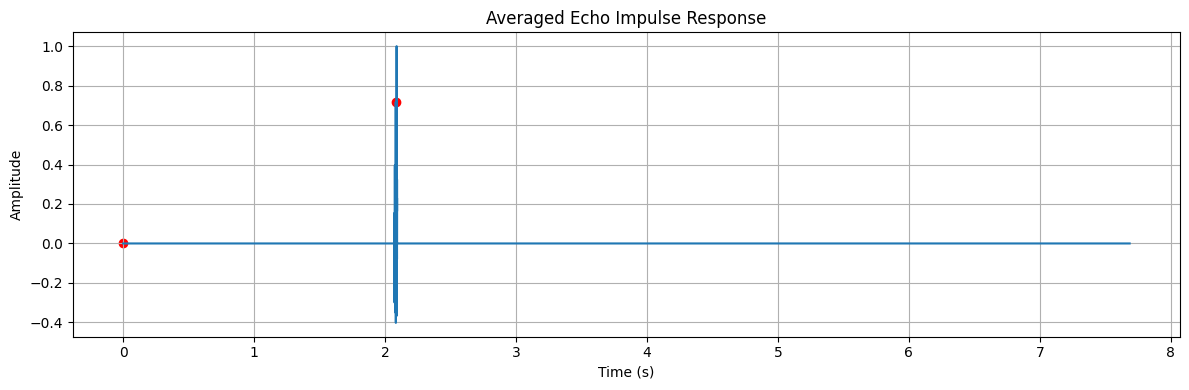

In [2]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import correlate, find_peaks

# -----------------------------
# USER SETTINGS
# -----------------------------
files = [
    "test_echo_1.wav",
    "test_echo_2.wav",
    "test_echo_3.wav",
    "test_echo_4.wav",
    "test_echo_5.wav"
]

MIN_ECHO_DELAY = 0.05    # seconds
PEAK_THRESHOLD = 0.4     # relative
WINDOW_MS = 10           # averaging window

# -----------------------------
# LOAD RECORDINGS
# -----------------------------
signals = []
fs = None

for f in files:
    y, fs = sf.read(f)
    y = y[:,0] if y.ndim > 1 else y
    signals.append(y)

# -----------------------------
# ALIGN USING DIRECT SOUND
# -----------------------------
ref = signals[0]
aligned = []

for y in signals:
    corr = correlate(y, ref, mode='full')
    shift = np.argmax(corr) - len(ref) + 1
    y_aligned = np.roll(y, -shift)
    aligned.append(y_aligned)

min_len = min(len(y) for y in aligned)
aligned = np.array([y[:min_len] for y in aligned])

# -----------------------------
# TEMP AVERAGE FOR PEAK DETECTION
# -----------------------------
temp_avg = np.mean(aligned, axis=0)
temp_avg /= np.max(np.abs(temp_avg))

# -----------------------------
# DETECT ECHO PEAK
# -----------------------------
peaks, props = find_peaks(np.abs(temp_avg), height=PEAK_THRESHOLD)
peaks = peaks[peaks > int(MIN_ECHO_DELAY * fs)]

if len(peaks) == 0:
    raise ValueError("❌ No echo detected. Try a different recording location.")

echo_peak = peaks[0]
print(f"✅ Echo detected at {echo_peak/fs:.3f} seconds")

# -----------------------------
# WINDOWED AVERAGING (KEY STEP)
# -----------------------------
W = int(WINDOW_MS * fs / 1000)
h_echo = np.zeros(min_len)

for p in [0, echo_peak]:
    segments = []
    for y in aligned:
        segments.append(y[p-W:p+W])
    h_echo[p-W:p+W] = np.mean(segments, axis=0)

# -----------------------------
# NORMALIZE & SAVE
# -----------------------------
h_echo /= np.max(np.abs(h_echo))
sf.write("averaged_echo_ir.wav", h_echo, fs)

print("📁 Saved averaged echo impulse response as 'averaged_echo_ir.wav'")

# -----------------------------
# PLOT
# -----------------------------
t = np.arange(len(h_echo)) / fs

plt.figure(figsize=(12,4))
plt.plot(t, h_echo)
plt.scatter([0, echo_peak/fs], [h_echo[0], h_echo[echo_peak]], color='red')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Averaged Echo Impulse Response")
plt.grid(True)
plt.tight_layout()
plt.show()
